In [ ]:
# !pip install peft accelerate bitsandbytes
!pip install --upgrade datasets fsspec trl wandb transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
import torch
from datasets import features
from PIL import Image

In [ ]:
dataset_name = "openbmb/RLAIF-V-Dataset"
# model_name = "liuhaotian/llava-v1.6-mistral-7b"
# model_name = 'llava-hf/llava-v1.6-mistral-7b-hf'
# model_name = 'SurfaceData/llava-v1.6-mistral-7b-sglang'
# model_name = 'google/paligemma-3b-pt-224'

In [ ]:
try:
    ds = load_dataset(dataset_name, split="train[:10%]")
    print("Dataset loaded successfully!")
except ValueError as e:
    print(f"Failed to load dataset: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset loaded successfully!


In [ ]:
ds

Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path'],
    num_rows: 8313
})

In [ ]:
ds[1]

{'ds_name': 'RLAIF-V',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x848>,
 'question': 'how many families?',
 'chosen': 'The image shows a Union Organization table setup with 18,000 families.',
 'rejected': 'The image does not provide any information about families.',
 'origin_dataset': 'TextVQA',
 'origin_split': '{"model": "OmniLMM-12B", "feedback_model": "OmniLMM-12B", "type": "question_answering"}',
 'idx': 'OmniLMM-12B_OmniLMM-12B_1',
 'image_path': 'TextVQA/train_images/8733d0a1351be922.jpg'}

In [ ]:
from transformers import AutoProcessor
from transformers import AutoModelForVision2Seq

In [ ]:
# from transformers BitsAndBytesConfig
# from peft import get_peft_model, LoraConfig

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
# )

In [ ]:
model_name = 'HuggingFaceTB/SmolVLM-256M-Instruct'

processor = AutoProcessor.from_pretrained(model_name, do_image_splitting=False)
model = AutoModelForVision2Seq.from_pretrained(model_name,
                                              device_map="auto", torch_dtype=torch.bfloat16)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     lora_dropout=0.1,
#     bias="none",
#     target_modules="all-linear" # Depends on model
# )

# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()

In [ ]:
def format(example):
    # Prepare the input for the chat template
    prompt = [
        {
            "role": "user",
            "content": [{"type": "image"}, {"type": "text", "text": example["question"]}],
        },
    ]
    chosen = [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": example["chosen"]}],
        },
    ]
    rejected = [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": example["rejected"]}],
        },
    ]
    # Apply the chat template
    prompt = processor.apply_chat_template(prompt, tokenize=False)
    chosen = processor.apply_chat_template(chosen, tokenize=False)
    rejected = processor.apply_chat_template(rejected, tokenize=False)
    # Resize the image to ensure it fits within the maximum allowable
    # size of the processor to prevent OOM errors.
    max_size = processor.image_processor.size["longest_edge"]
    example["image"].thumbnail((max_size, max_size))
    return {"images": [example["image"]], "prompt": prompt, "chosen": chosen, "rejected": rejected}

dataset = ds.map(format, remove_columns=ds.column_names)


Map:   0%|          | 0/8313 [00:00<?, ? examples/s]

In [ ]:
print(dataset[1])

{'chosen': '<|im_start|>Assistant: The image shows a Union Organization table setup with 18,000 families.<end_of_utterance>\n', 'rejected': '<|im_start|>Assistant: The image does not provide any information about families.<end_of_utterance>\n', 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x848 at 0x7D7F7604A890>], 'prompt': '<|im_start|>User:<image>how many families?<end_of_utterance>\n'}


In [ ]:
# Make sure that the images are decoded, it prevents from storing bytes.
f = dataset.features
f["images"] = features.Sequence(features.Image(decode=True))  # to avoid bytes
dataset = dataset.cast(f)

# Split the dataset
splits = dataset.train_test_split(test_size=0.1)

# Access the splits
train_dataset = splits["train"]
test_dataset = splits["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Casting the dataset:   0%|          | 0/8313 [00:00<?, ? examples/s]

Train dataset size: 7481
Test dataset size: 832


In [ ]:
from trl import ORPOConfig, ORPOTrainer

In [ ]:
!wandb login

In [ ]:
config = ORPOConfig(
    output_dir="smolvlm_finetuned",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,  # ↑ changed
    lr_scheduler_type='cosine',
    warmup_ratio=0.03,  # ↑ added
    num_train_epochs=5,  # ↓ reduced
    logging_steps=50,
    bf16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": True},
    remove_unused_columns=False,
    max_prompt_length=512,
    max_length=1024,
    report_to="wandb",
    do_eval=True,
    eval_strategy="steps",
    eval_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="loss"
)

In [ ]:
train_dataset, test_dataset

(Dataset({
     features: ['chosen', 'rejected', 'images', 'prompt'],
     num_rows: 7481
 }),
 Dataset({
     features: ['chosen', 'rejected', 'images', 'prompt'],
     num_rows: 832
 }))

In [ ]:
trainer = ORPOTrainer(model=model, args=config, train_dataset=train_dataset,
                      processing_class = processor.tokenizer, eval_dataset = test_dataset)

Map:   0%|          | 0/7481 [00:00<?, ? examples/s]

Map:   0%|          | 0/7481 [00:00<?, ? examples/s]

Map:   0%|          | 0/7481 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: zaynhyder15 (zaynhyder15-brandenburgische-technische-universit-t-cott) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Runtime,Samples Per Second,Steps Per Second,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen,Nll Loss,Log Odds Ratio,Log Odds Chosen
50,3.785100,3.582873,53.887500,15.440000,1.930000,-0.294402,-0.296423,0.516827,0.002022,-2.964233,-2.944015,-0.018663,-0.046923,3.511703,-0.711697,0.020165
100,3.367100,3.184211,53.741200,15.482000,1.935000,-0.263138,-0.264834,0.526442,0.001696,-2.648336,-2.631377,0.009680,-0.017774,3.113281,-0.709289,0.017135
150,3.024300,2.892864,53.557900,15.535000,1.942000,-0.231195,-0.232419,0.518029,0.001224,-2.324188,-2.311950,0.057388,0.031222,2.821846,-0.710176,0.012610
200,2.774800,2.683325,53.680600,15.499000,1.937000,-0.207046,-0.208013,0.522837,0.000967,-2.080126,-2.070457,-0.006302,-0.032444,2.612006,-0.713190,0.009596
250,2.594600,2.544191,53.678200,15.500000,1.937000,-0.194849,-0.195715,0.518029,0.000866,-1.957153,-1.948488,-0.110166,-0.135677,2.472646,-0.715447,0.008155
300,2.435500,2.355373,53.628200,15.514000,1.939000,-0.192677,-0.193468,0.513221,0.000791,-1.934680,-1.926773,-0.205970,-0.231737,2.283798,-0.715747,0.007545
350,2.315100,2.314120,53.559900,15.534000,1.942000,-0.190814,-0.191609,0.516827,0.000795,-1.916091,-1.908142,-0.198956,-0.225024,2.242466,-0.716546,0.007475
400,2.286600,2.296843,53.649200,15.508000,1.939000,-0.189855,-0.190645,0.521635,0.000789,-1.906445,-1.898552,-0.183199,-0.208510,2.225189,-0.716547,0.007409
450,2.273200,2.286600,53.688900,15.497000,1.937000,-0.189291,-0.190081,0.519231,0.000790,-1.900810,-1.892911,-0.159900,-0.185969,2.214929,-0.716711,0.007364
500,2.265200,2.280753,53.537900,15.540000,1.943000,-0.188952,-0.189776,0.519231,0.000824,-1.897763,-1.889519,-0.156495,-0.181888,2.209088,-0.716654,0.007808


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


TrainOutput(global_step=1170, training_loss=2.445875982952933, metrics={'train_runtime': 9787.0769, 'train_samples_per_second': 3.822, 'train_steps_per_second': 0.12, 'total_flos': 0.0, 'train_loss': 2.445875982952933, 'epoch': 5.0})

In [ ]:
save_dir = '/content/ft_smolvlm'

model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

['/content/ft_smolvlm/processor_config.json']

Quantization

In [ ]:
!pip install quanto
!pip install git+https://github.com/huggingface/accelerate.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install optimum-quanto

In [ ]:
from transformers import AutoProcessor
from transformers import AutoModelForVision2Seq, QuantoConfig
import torch

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "/content/ft_smolvlm"

ft_processor = AutoProcessor.from_pretrained(model_id)

quantization_config = QuantoConfig(weights="int8")

quantized_model = AutoModelForVision2Seq.from_pretrained(model_id, device_map="auto", quantization_config=quantization_config)

In [ ]:
print(quantized_model)

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-11): 12 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): QLinear(in_features=768, out_features=768, bias=True)
              (v_proj): QLinear(in_features=768, out_features=768, bias=True)
              (q_proj): QLinear(in_features=768, out_features=768, bias=True)
              (out_proj): QLinear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): QLinear(in_featu

In [ ]:
ds

Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path'],
    num_rows: 8313
})

In [ ]:
s = np.random.randint(0, len(ds))

user_message = ds[s]['question']
image = ds[s]['image']

print("Sample number: ",s, "\nQuestion: " + user_message,)

Sample number:  7971 
Question: How many signs are there?


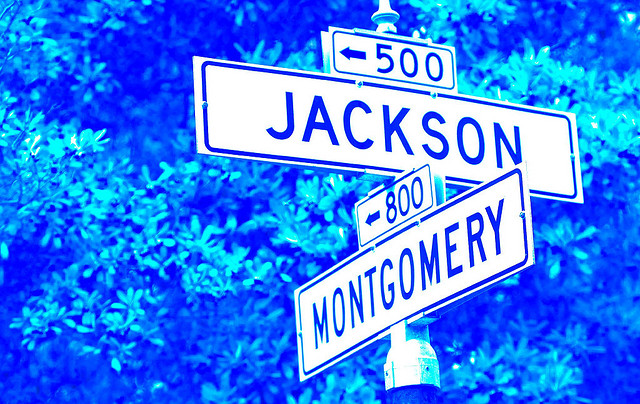

In [ ]:
image

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": user_message}
        ]
    },
]

# Prepare inputs
prompt = ft_processor.apply_chat_template(messages, add_generation_prompt=True)
print("Prompt : ", prompt, "\n")
inputs = ft_processor(text=prompt, images=[image], return_tensors="pt")

inputs = inputs.to(DEVICE)


# Generate outputs
generated_ids = quantized_model.generate(**inputs, max_new_tokens=250)
generated_texts = ft_processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

Prompt :  <|im_start|>User:<image>How many signs are there?<end_of_utterance>
Assistant: 



In [ ]:
print(generated_texts[0])

User:How many signs are there?
Assistant: There are four signs.


##Hosting

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def inference(image, user_message):
    # Compose the multimodal prompt as required by your processor
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": user_message}
            ]
        },
    ]

    # Apply chat template to format the input prompt
    prompt = ft_processor.apply_chat_template(messages, add_generation_prompt=True)

    # Process the prompt and image to model inputs
    inputs = ft_processor(text=prompt, images=[image], return_tensors="pt").to(DEVICE)

    # Generate outputs from the quantized model
    generated_ids = quantized_model.generate(**inputs, max_new_tokens=250)

    # Decode output tokens to text
    generated_texts = ft_processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_texts[0]  # Return the first generated text


In [ ]:
iface = gr.Interface(
    fn=inference,
    inputs=[
        gr.Image(type="pil", label="Input Image"),
        gr.Textbox(lines=2, placeholder="Ask something about the image...", label="User Message")
    ],
    outputs=gr.Textbox(label="Model Response"),
    title="(Quantized) Multimodal Chat",
    description="Upload an image and ask a question to get a response from the model.",
    allow_flagging="never"
)


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


In [ ]:
iface.launch(debug=True)